In [130]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import yfinance as yf

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Functions

In [159]:
# %load detect_sum.py
"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""

from __future__ import division, print_function
import numpy as np

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.
    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).
    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.
    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.
    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.
    See this IPython Notebook [2]_.
    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb
    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)
    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)
    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

## Loading data

In [180]:
df = pd.read_csv("dataset/filtered_data.csv")
df.set_index('Data e Hora', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
title = 'Energy production (2011 - 2025)'
title_renewable = 'Renewable Energy Production (2011 - 2025)'
title_non_renewable = 'Non-Renewable Energy Production (2011 - 2025)'
df.index = df.index + pd.DateOffset(months=6)
serie = "Energy Production"
serie_renewable = "Energy Renewable"
serie_non_renewable = "Energy Non-Renewable"
xlab = 'days/Year'
ylab = 'energy production (GWh)'
seasonal_periods = 12

color_non_renewable = '#b51b2b' 
color_renewable = '#2bb314' 


#### Nota 
- Nota: Aplicando uma escala logarítmica aos dados, pode transformar um modelo multiplicativo num aditivo
#### Tipo de modelo que esperamos:
- 'additive' - A amplitude do efeito sazonal mantém-se constante todos os anos
- 'multiplicative' - Os efeitos sazonais e outros atuam proporcionalmente sobre a série

In [133]:
Renoable_column = ['producao_renovavel','hidrica' ,'biomassa','eolica','solar','ondas']
NoneRenoable_column = ['producao_nao_renovavel','termica' ,'gas_natural','carvao','producao_por_bombagem']
Export_import_column = ['exportacao','importacao'] 

# Análise Descritiva

## Informação geral

In [134]:
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-07-01,107.975628,73.076341,63.952042,2.142578,0.122491,NaN,6.859230,34.484478,4.3443,28.367837,1.772341,0.414810,12.4186,0.0852
2011-07-02,109.657562,71.219553,62.732572,1.469945,0.197608,NaN,6.819428,37.876984,0.7383,35.343969,1.794715,0.561025,20.8615,0.0000
2011-07-03,150.642916,74.660080,63.158904,4.503582,0.166772,NaN,6.830821,74.808327,14.9438,55.179956,4.684572,1.174509,13.4903,1.0916
2011-07-04,159.833303,101.106584,64.904843,28.734425,0.256511,NaN,7.210805,58.567678,4.8496,48.985982,4.732096,0.159041,9.3552,0.7629
2011-07-05,170.854279,133.687873,67.566754,58.869586,0.208719,NaN,7.042814,36.428947,4.6337,27.003927,4.791320,0.737460,6.7881,6.8363


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5184 entries, 2011-07-01 to 2025-09-11
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   producao_total          5184 non-null   float64
 1   producao_renovavel      5184 non-null   float64
 2   hidrica                 5184 non-null   float64
 3   eolica                  5184 non-null   float64
 4   solar                   5184 non-null   float64
 5   ondas                   2343 non-null   float64
 6   biomassa                5184 non-null   float64
 7   producao_nao_renovavel  5184 non-null   float64
 8   carvao                  5167 non-null   float64
 9   gas_natural             5184 non-null   float64
 10  termica                 5184 non-null   float64
 11  producao_por_bombagem   5184 non-null   float64
 12  importacao              5184 non-null   float64
 13  exportacao              5184 non-null   float64
dtypes: float64(14)
memory 

- producao_renovavel é a agregação das colunas hidrica, eolica, solar, ondas, biomassa
- producao_nao_renovavel é a agregação das colunas carvao, gas_natural, termica, producao_por_bombagem


In [136]:
# print(df[Renoable_column].describe(percentiles=[.1, .25, .5, .75, .9]))
# print(df[NoneRenoable_column].describe(percentiles=[.1, .25, .5, .75, .9]))
# print(df[Export_import_column].describe(percentiles=[.1, .25, .5, .75, .9]))

## Visualização dos dados


### Visão geral

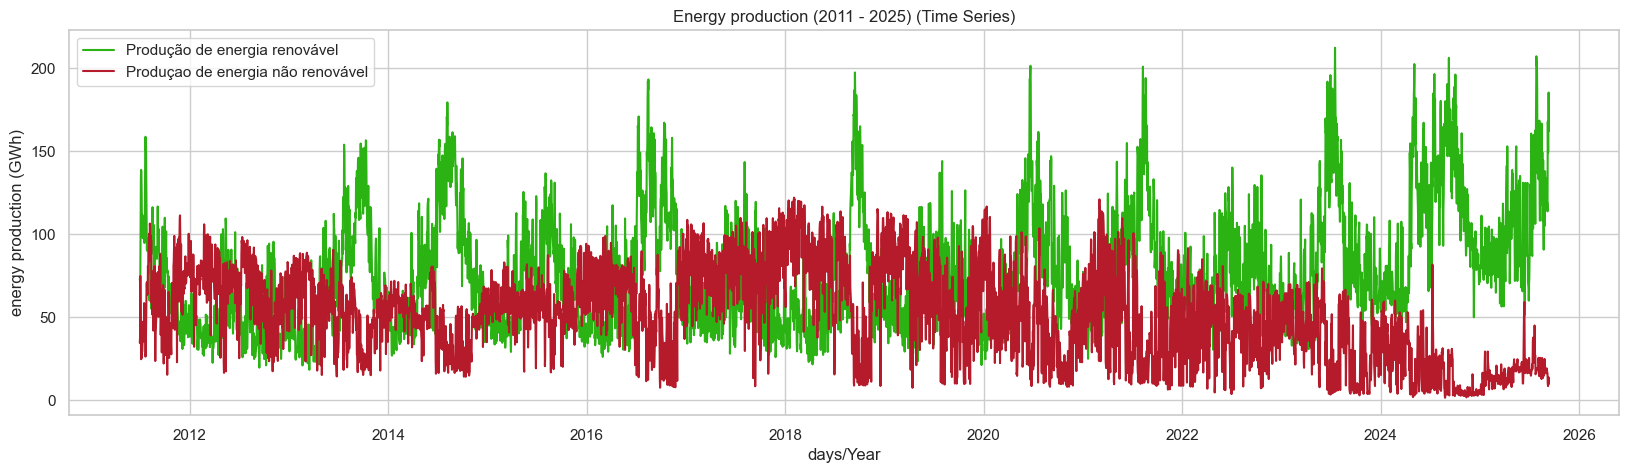

In [137]:
plt.figure(figsize=(20,5))
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.plot(df.index, df['producao_renovavel'], label='Produção de energia renovável', color=color_renewable)
plt.plot(df.index, df['producao_nao_renovavel'], label='Produçao de energia não renovável',color=color_non_renewable)
plt.legend()
plt.grid(True)

### Histogramas

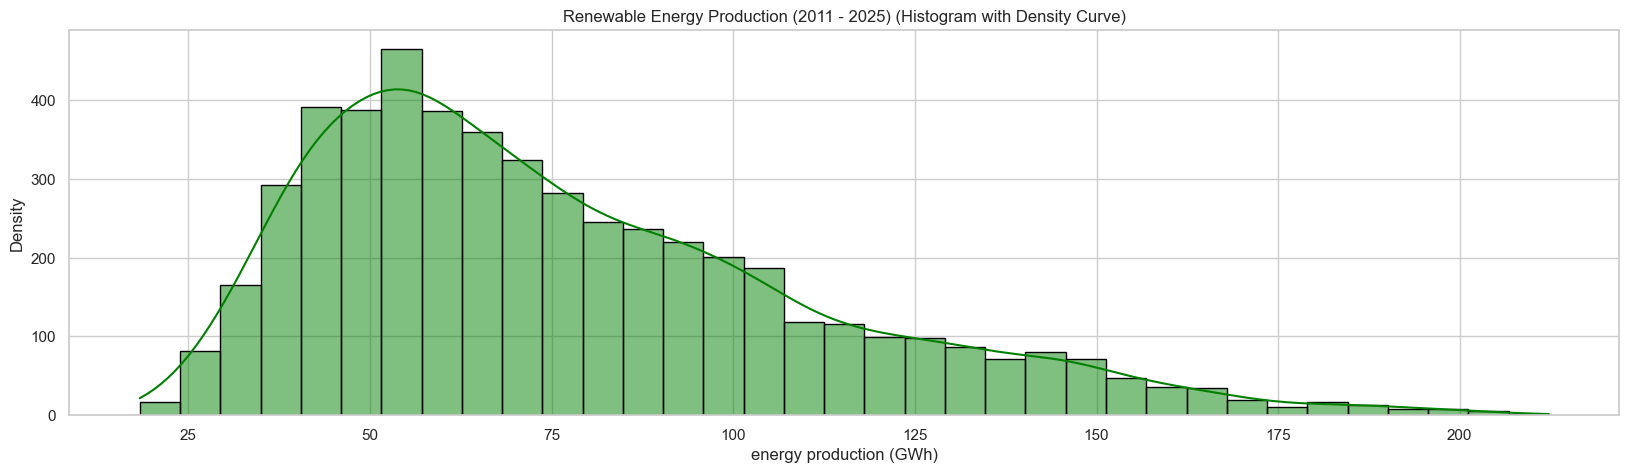

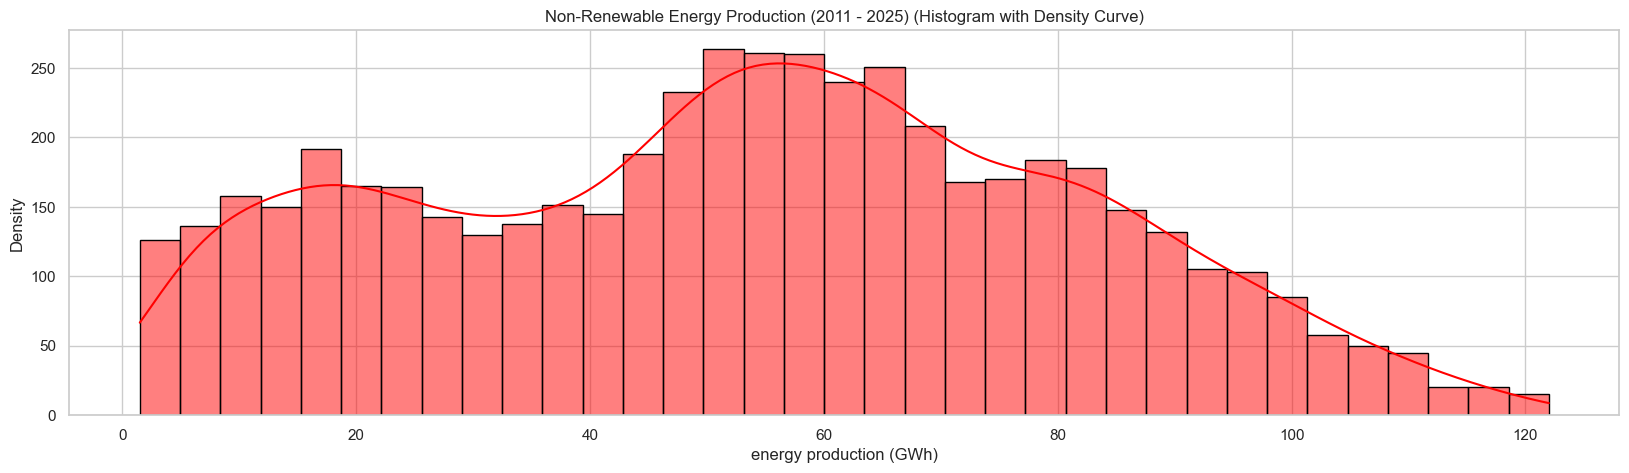

In [138]:
plt.figure(figsize=(20,5))
sns.histplot(df['producao_renovavel'], 
             bins=35, color='green', 
             kde=True,
             edgecolor='black')
plt.title(title_renewable +' (Histogram with Density Curve)')
plt.ylabel('Density')
plt.xlabel(ylab)
plt.grid(True)

plt.figure(figsize=(20,5))
sns.histplot(df['producao_nao_renovavel'], 
             bins=35, color='red', 
             kde=True,
             edgecolor='black')
plt.title(title_non_renoable +' (Histogram with Density Curve)')
plt.ylabel('Density')
plt.xlabel(ylab)
plt.grid(True)

### Função de distribuição acumulativa

In [139]:
df_non_renewable = df['producao_nao_renovavel'].to_frame()
df_renewable = df['producao_renovavel'].to_frame()    

In [ ]:
# Cumulative Distribution Function for Renewable Energy Production
cdf_renewable = df_renewable.sum(axis=1).value_counts().sort_index().div(len(df)).cumsum()
plt.figure(figsize=(20, 5))
cdf_renewable.plot(linewidth=2, color='green')
plt.title(title_renewable + ' (Cumulative Distribution Function)')
plt.ylabel('Probability')
plt.xlabel(ylab)
minVal = df_renewable.values.min()
q25 = np.quantile(df_renewable.values, .25)
medianVal = np.quantile(df_renewable.values, .5)
q75 = np.quantile(df_renewable.values, .75)
data = [(minVal, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r',
      (minVal, medianVal), (.5, .5), 'r', (medianVal, medianVal), (0, .5), 'r',
      (minVal, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r']
plt.plot(*data, ls='--')
plt.text(minVal + (q25 - minVal) / 2, 0.27, "Q1", color='r', fontweight='bold')
plt.text(minVal + (medianVal - minVal) / 2, 0.52, "Median", color='r', fontweight='bold')
plt.text(minVal + (q75 - minVal) / 2, 0.77, "Q3", color='r', fontweight='bold')
plt.grid(True)
plt.show()

# Cumulative Distribution Function for Non-Renewable Energy Production
cdf_non_renewable = df_non_renewable.sum(axis=1).value_counts().sort_index().div(len(df)).cumsum()
plt.figure(figsize=(20, 5))
cdf_non_renewable.plot(linewidth=2, color='red')
plt.title(title_non_renewable + ' (Cumulative Distribution Function)')
plt.ylabel('Probability')
plt.xlabel(ylab)
minVal = df_non_renewable.values.min()
q25 = np.quantile(df_non_renewable.values, .25)
medianVal = np.quantile(df_non_renewable.values, .5)
q75 = np.quantile(df_non_renewable.values, .75)
data = [(minVal, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r',
      (minVal, medianVal), (.5, .5), 'r', (medianVal, medianVal), (0, .5), 'r',
      (minVal, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r']
plt.plot(*data, ls='--')
plt.text(minVal + (q25 - minVal) / 2, 0.27, "Q1", color='r', fontweight='bold')
plt.text(minVal + (medianVal - minVal) / 2, 0.52, "Median", color='r', fontweight='bold')
plt.text(minVal + (q75 - minVal) / 2, 0.77, "Q3", color='r', fontweight='bold')
plt.grid(True)
plt.show()

### Distribuição de valores por Ano

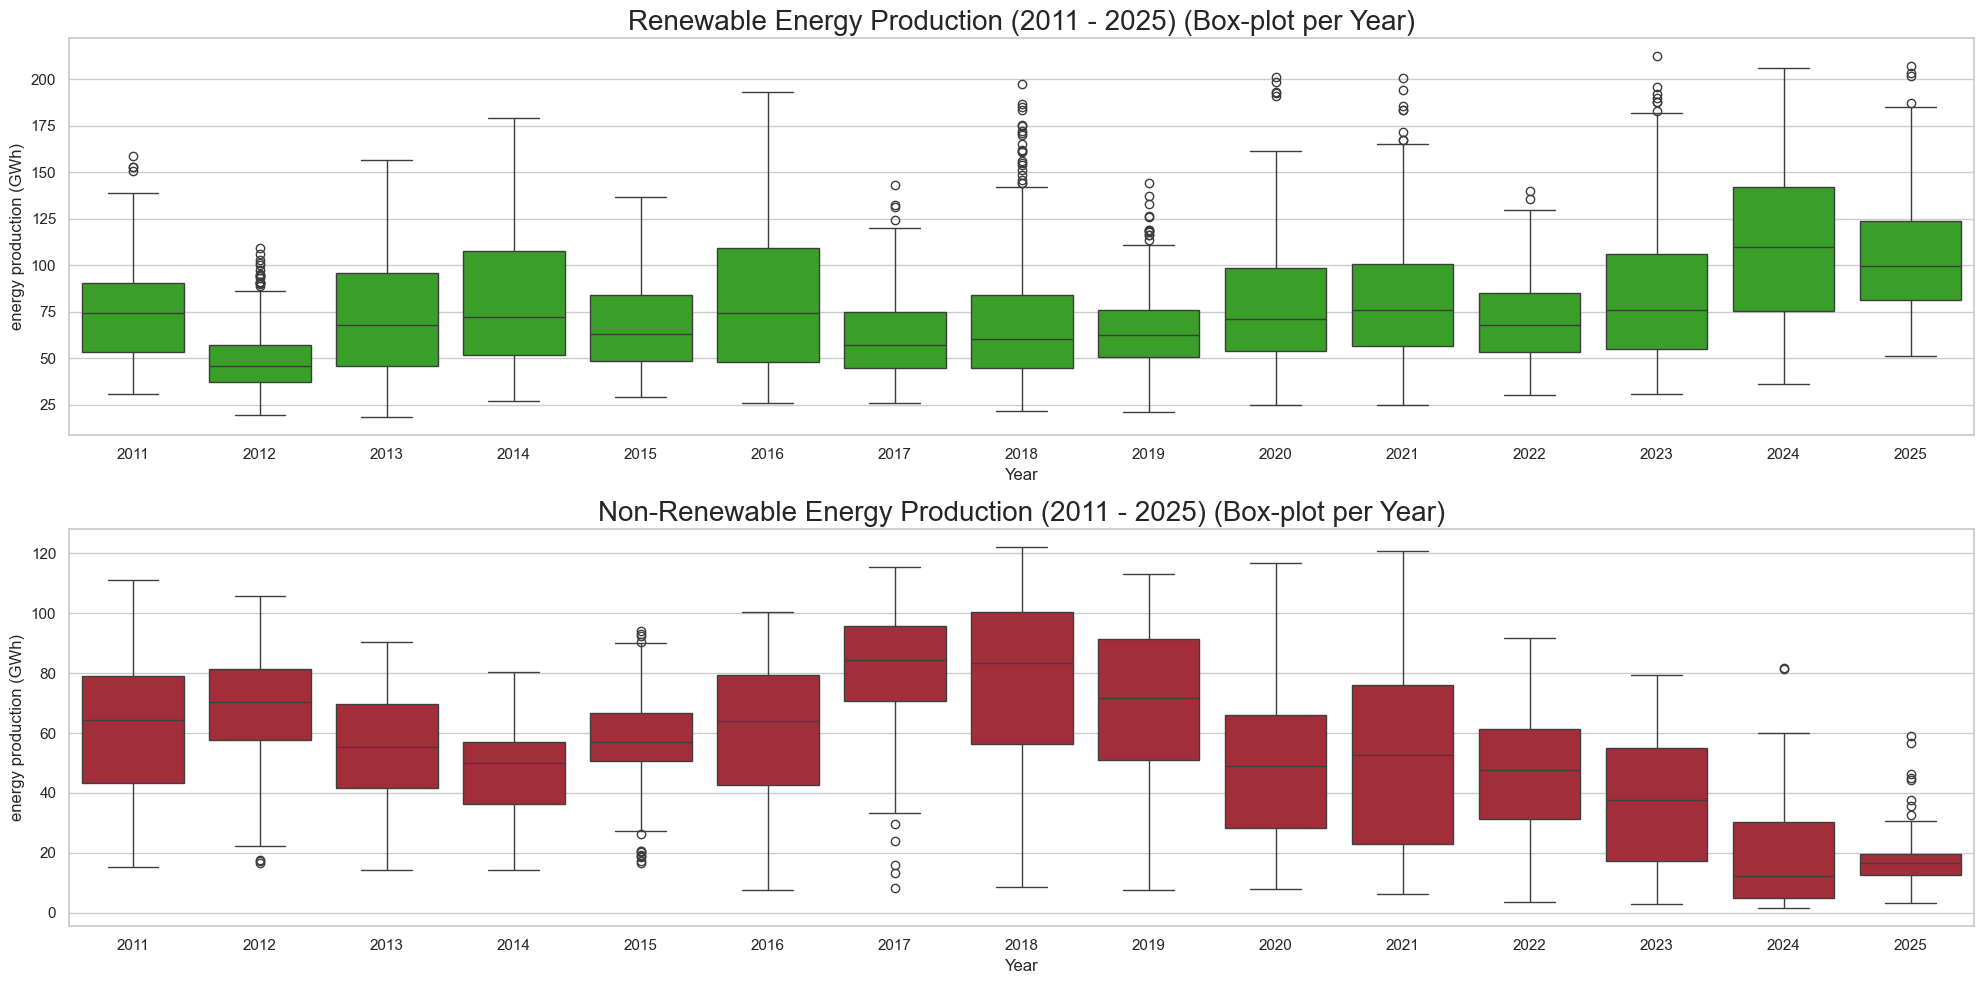

In [ ]:

plt.figure(figsize=(20, 10))

# Box plot for renewable energy production
plt.subplot(2, 1, 1)
box_plot = sns.boxplot(x=df.index.year, y='producao_renovavel', data=df_renewable,color=color_renewable)
box_plot.set_xlabel('Year')
box_plot.set_ylabel(ylab)
box_plot.set_title(title_renewable + ' (Box-plot per Year)', fontsize=20)

# Box plot for non-renewable energy production
plt.subplot(2, 1, 2)
box_plot = sns.boxplot(x=df.index.year, y='producao_nao_renovavel', data=df_non_renewable,color=color_non_renewable)
box_plot.set_xlabel('Year')
box_plot.set_ylabel(ylab)
box_plot.set_title(title_non_renewable + ' (Box-plot per Year)', fontsize=20)

plt.tight_layout()
plt.show()

### Análise das componentes das series

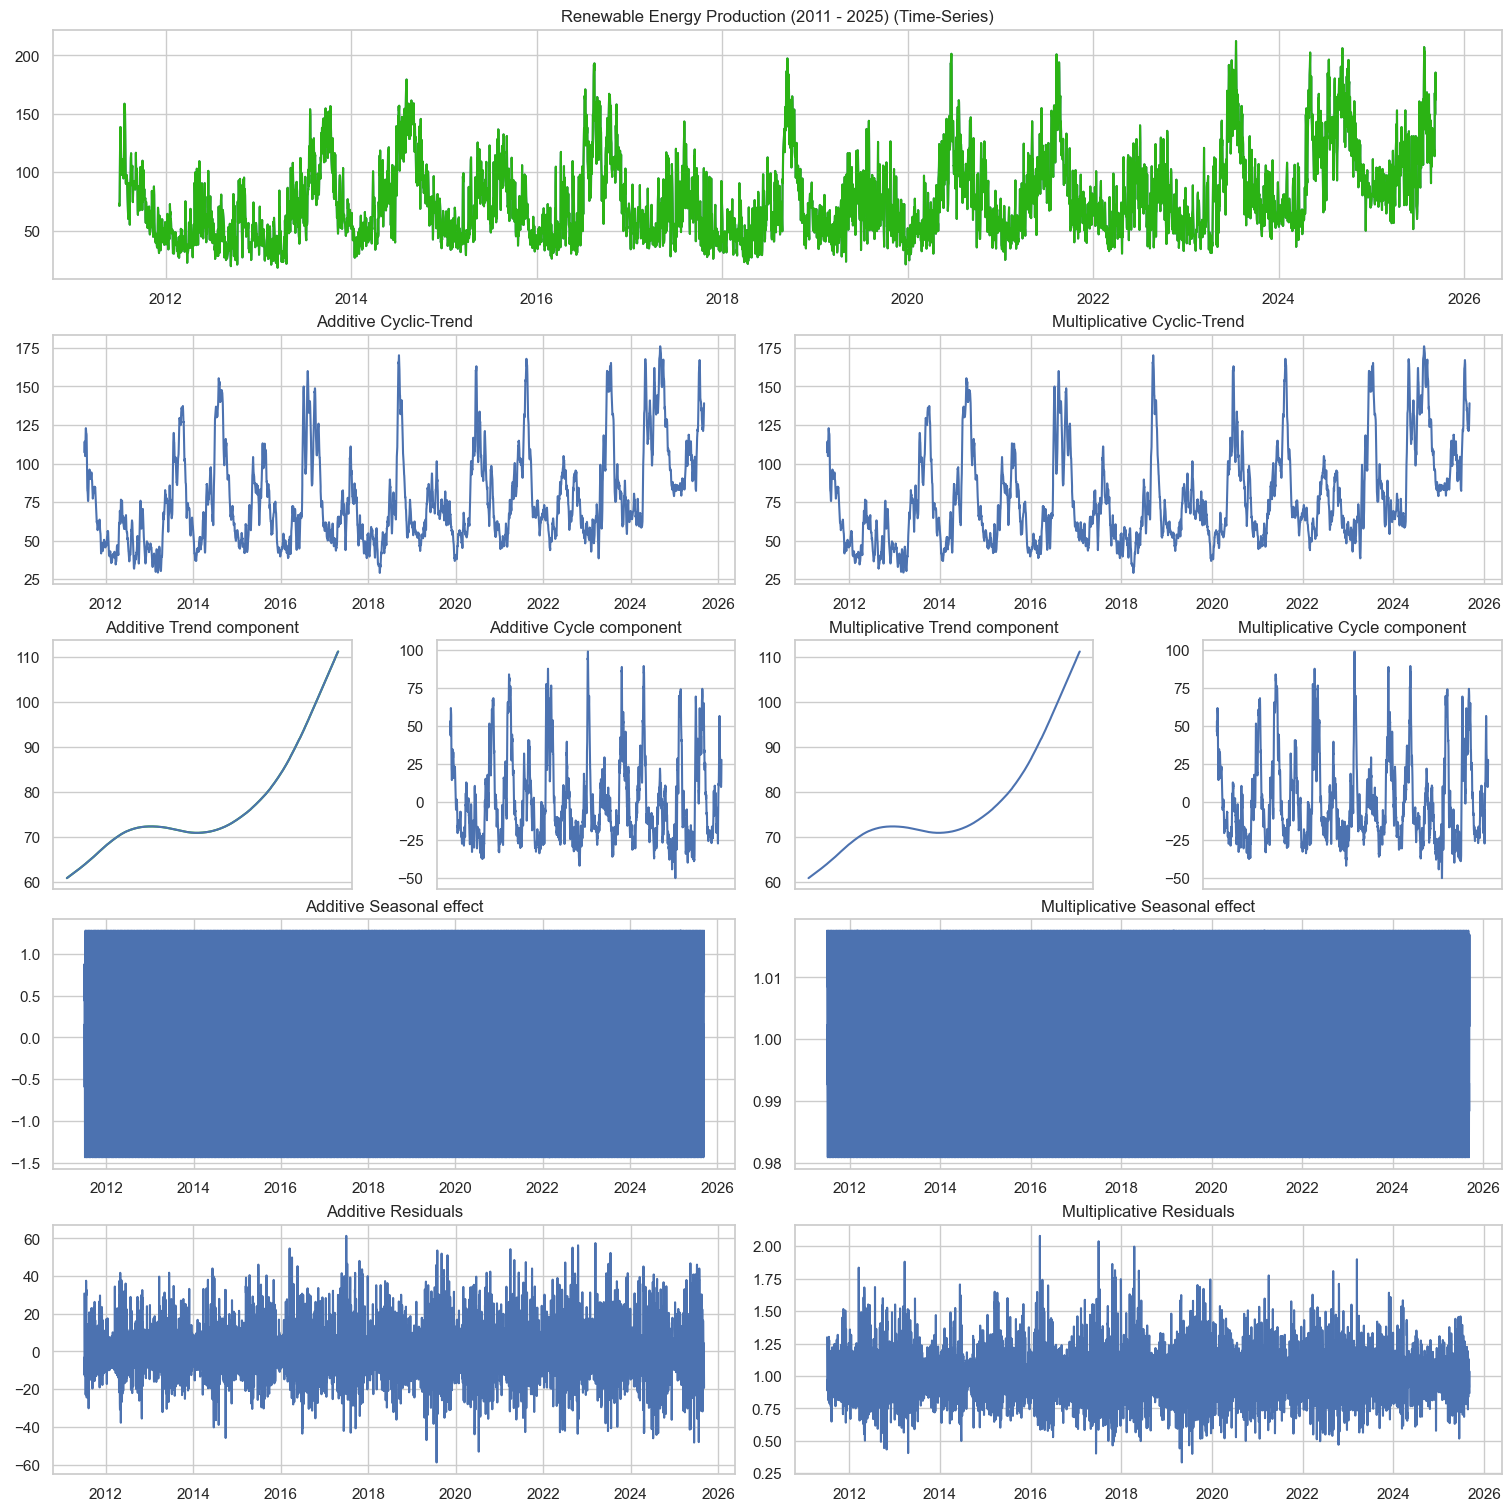

In [142]:
resultAdd = seasonal_decompose(df_renewable, model='additive',       period=seasonal_periods)
resultMul = seasonal_decompose(df_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend[resultMul.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df_renewable)
plt.plot(df_renewable, color=color_renewable)
plt.title(title_renewable + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd, color=color_renewable)
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')

# Multiplicative model
fig.add_subplot(spec[1, 2:])
plt.plot(resultMul.trend)
plt.title('Multiplicative Cyclic-Trend')
fig.add_subplot(spec[2, 2])
plt.plot(trendMul)
plt.xticks([])
plt.title('Multiplicative Trend component')
fig.add_subplot(spec[2, 3])
plt.plot(cycleMul)
plt.xticks([])
plt.title('Multiplicative Cycle component')
fig.add_subplot(spec[3, 2:])
plt.plot(resultMul.seasonal)
plt.title('Multiplicative Seasonal effect')
fig.add_subplot(spec[4, 2:])
plt.plot(resultMul.resid)
plt.title('Multiplicative Residuals')
plt.show()

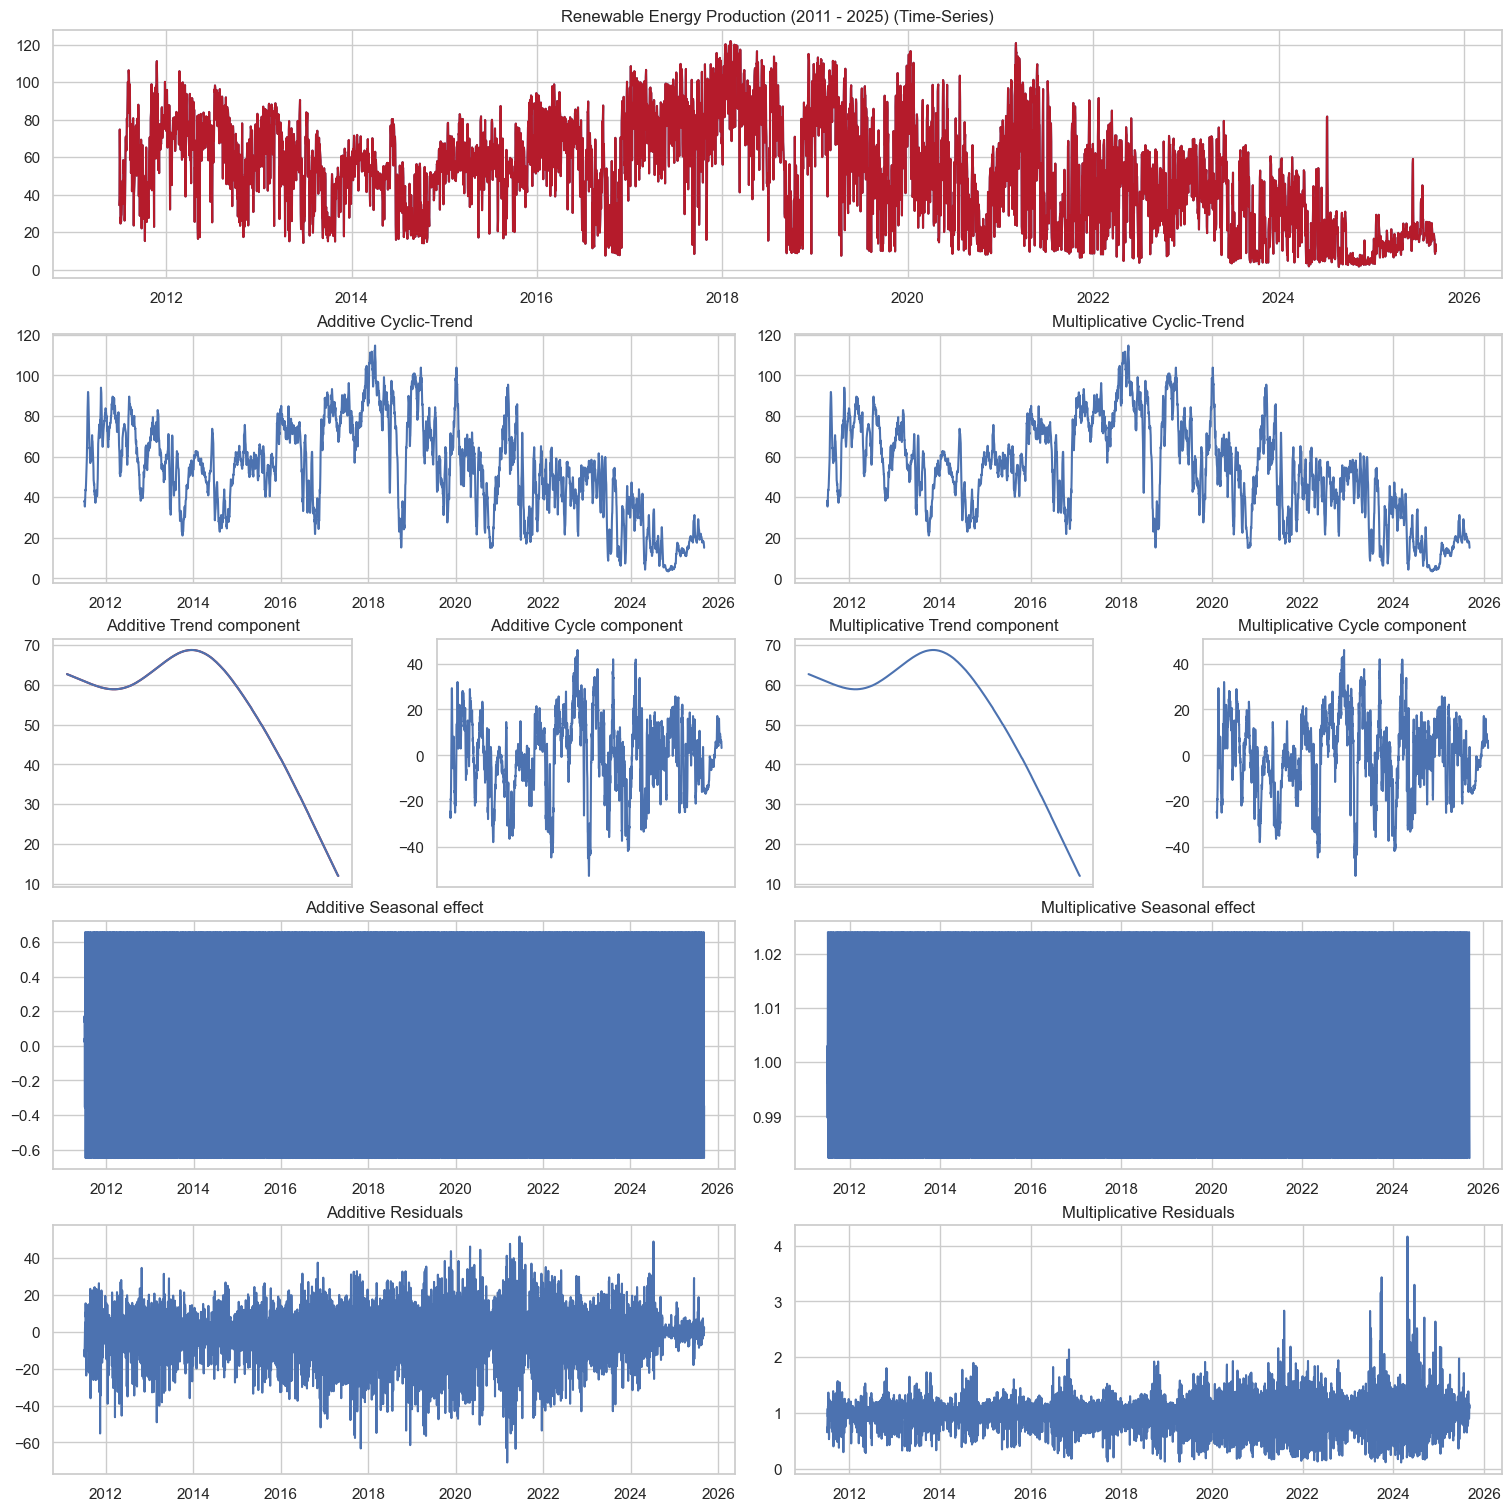

In [143]:
resultAdd = seasonal_decompose(df_non_renewable, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_non_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend[resultMul.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df_non_renewable)
plt.plot(df_non_renewable, color=color_non_renewable)
plt.title(title_renewable + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd, color=color_non_renewable)
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')

# Multiplicative model
fig.add_subplot(spec[1, 2:])
plt.plot(resultMul.trend)
plt.title('Multiplicative Cyclic-Trend')
fig.add_subplot(spec[2, 2])
plt.plot(trendMul)
plt.xticks([])
plt.title('Multiplicative Trend component')
fig.add_subplot(spec[2, 3])
plt.plot(cycleMul)
plt.xticks([])
plt.title('Multiplicative Cycle component')
fig.add_subplot(spec[3, 2:])
plt.plot(resultMul.seasonal)
plt.title('Multiplicative Seasonal effect')
fig.add_subplot(spec[4, 2:])
plt.plot(resultMul.resid)
plt.title('Multiplicative Residuals')
plt.show()

### Autocorrelação dos dados

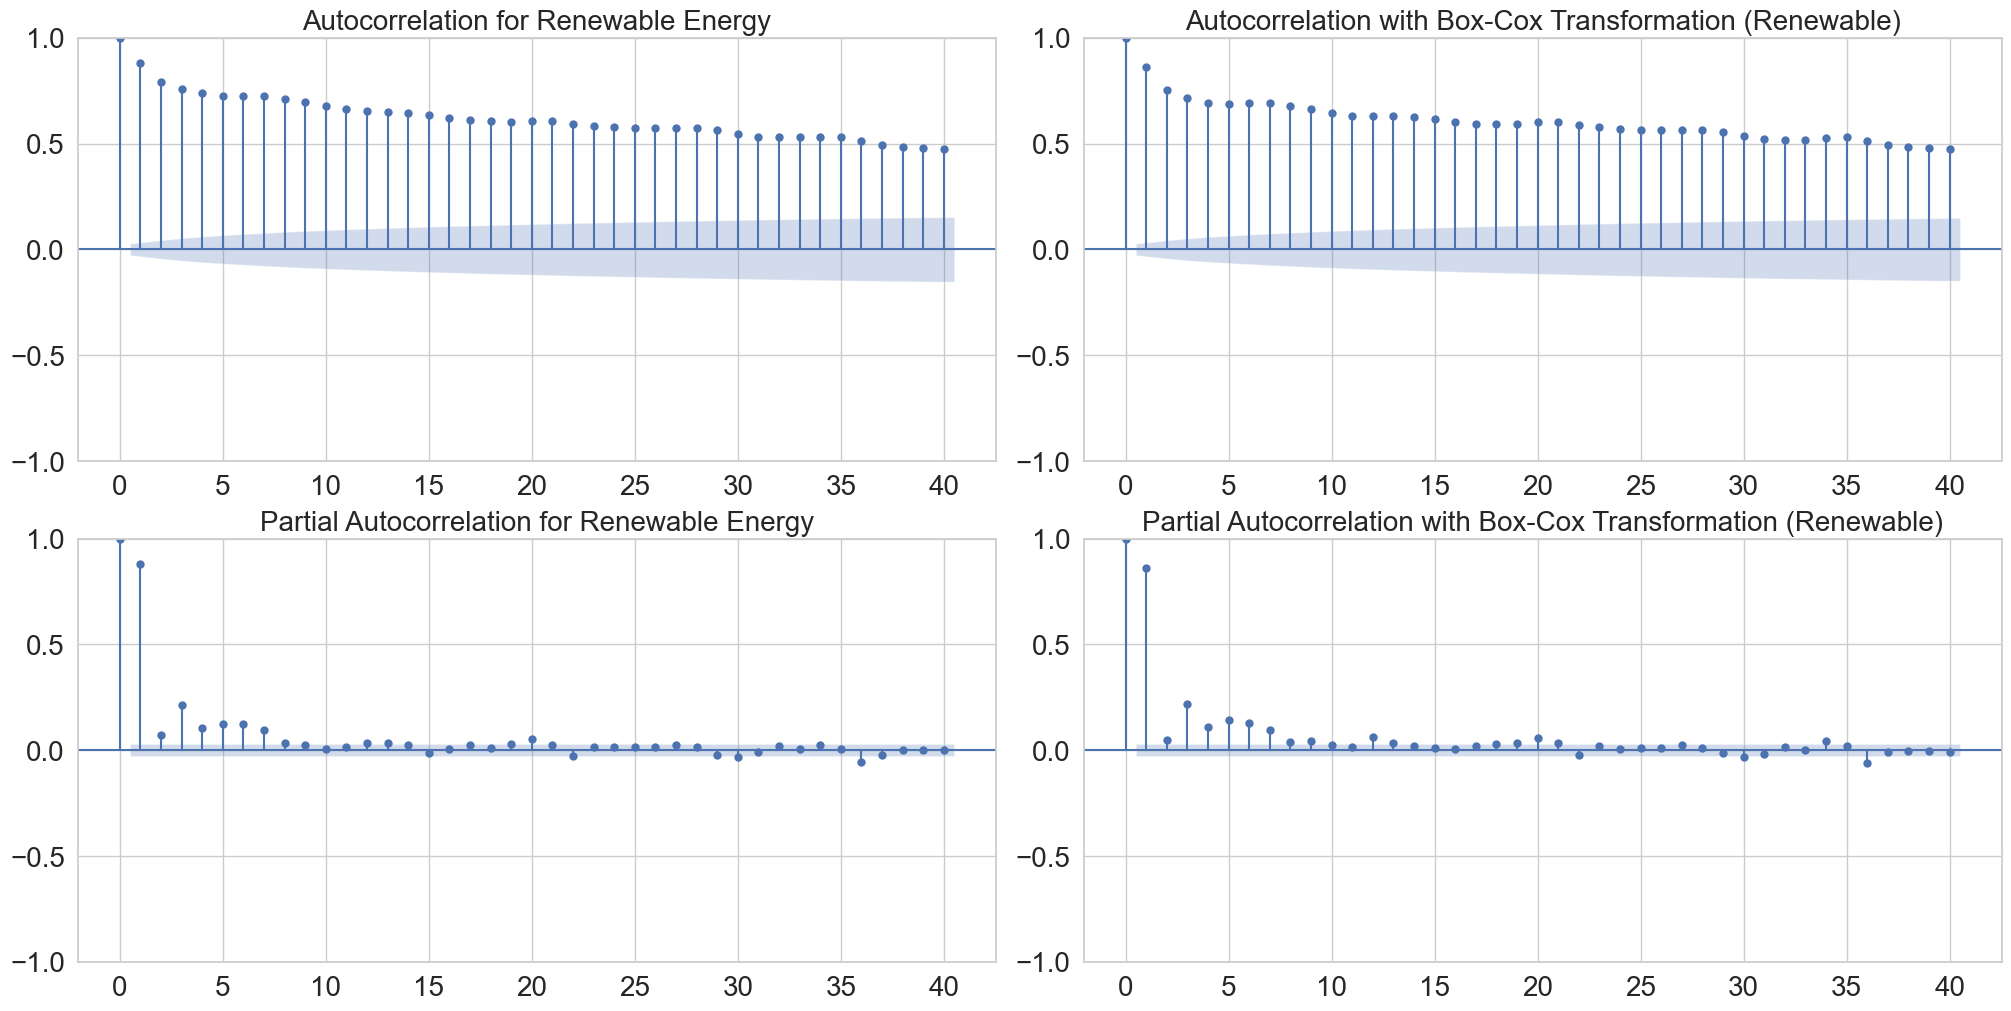

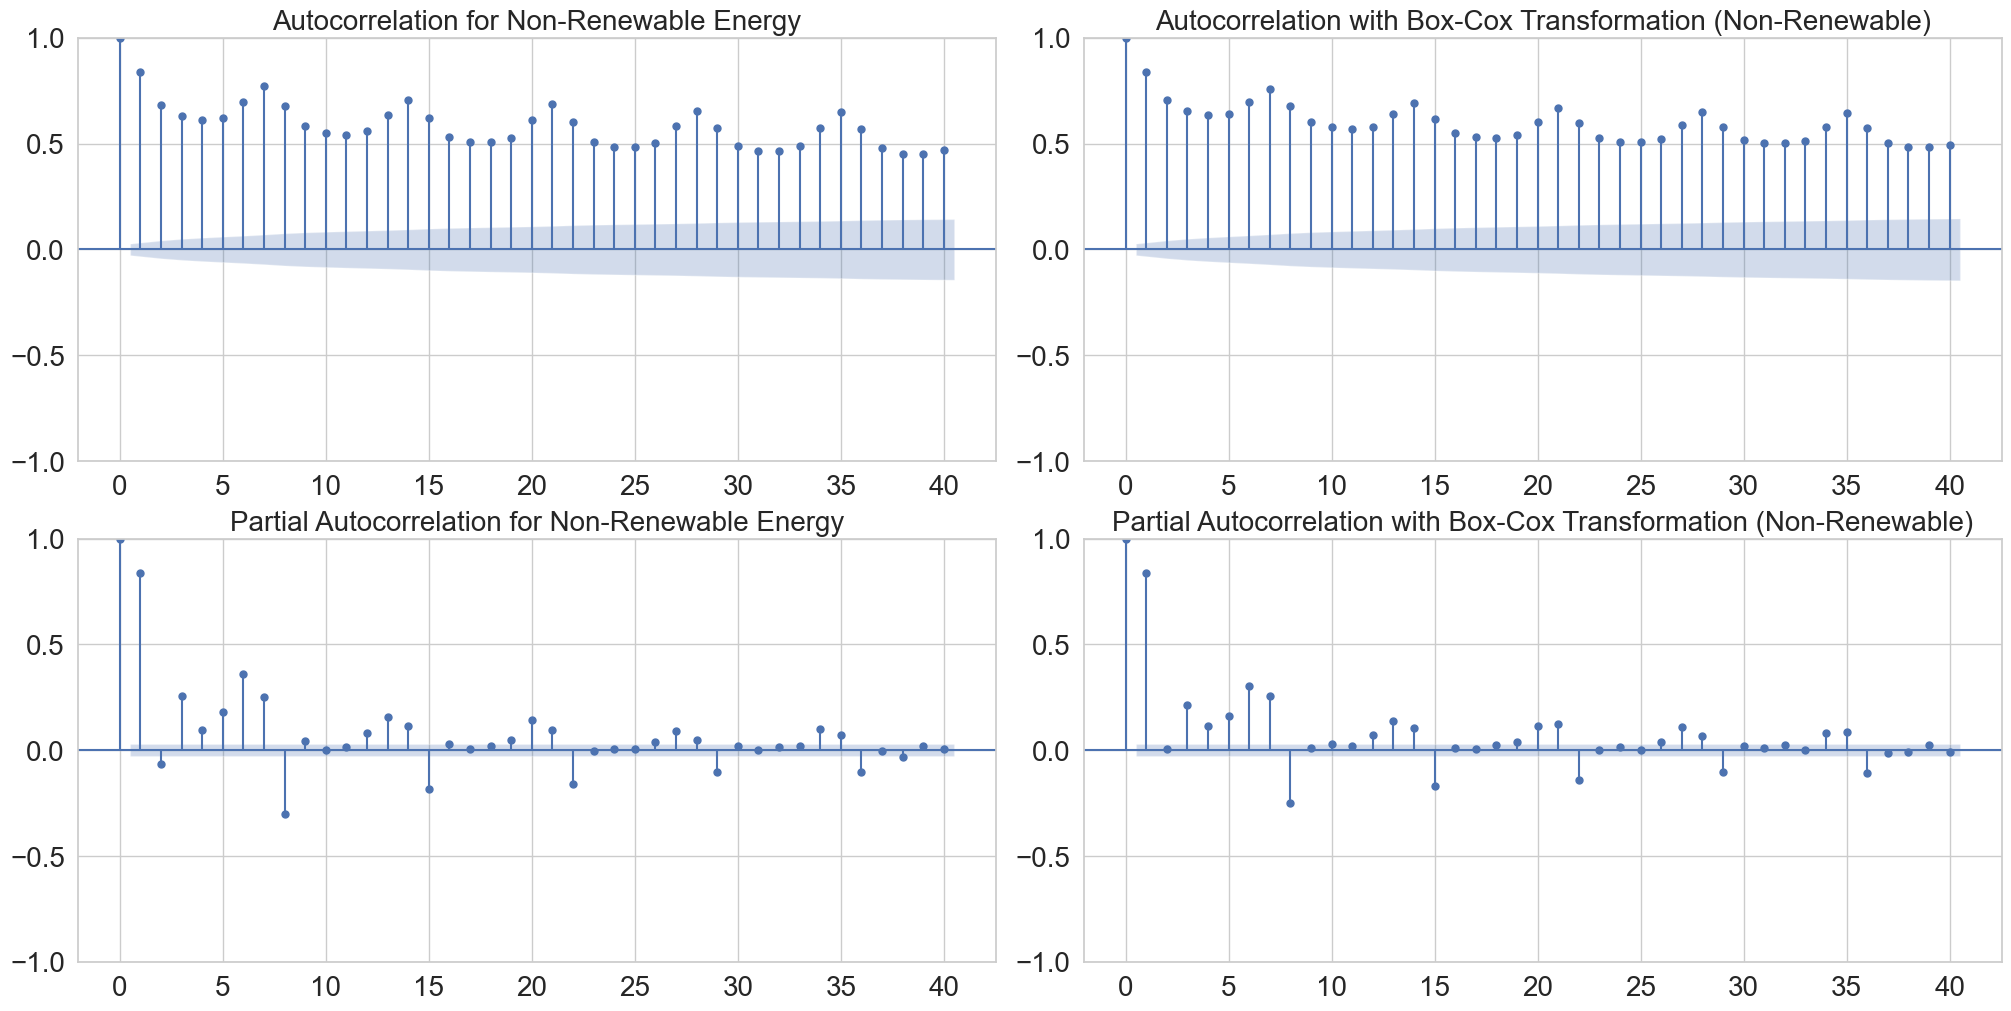

In [144]:
# Correlation plots
maxLags = 40

# Renewable energy
df_boxCox_renewable = stats.boxcox(df_renewable.values.flatten(), lmbda=0)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for renewable energy
ax_acf_renewable = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_renewable, lags=maxLags, ax=ax_acf_renewable)
ax_acf_renewable.set_title('Autocorrelation for Renewable Energy', fontsize=20)
ax_acf_renewable.tick_params(axis='both', which='major', labelsize=20)

# Partial auto-correlation function for renewable energy
ax_pacf_renewable = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_renewable, lags=maxLags, ax=ax_pacf_renewable)
ax_pacf_renewable.set_title('Partial Autocorrelation for Renewable Energy', fontsize=20)
ax_pacf_renewable.tick_params(axis='both', which='major', labelsize=20)

# Auto-correlation function for renewable energy transformed with Box-Cox
ax_acfBoxCox_renewable = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox_renewable, lags=maxLags, ax=ax_acfBoxCox_renewable)
ax_acfBoxCox_renewable.set_title('Autocorrelation with Box-Cox Transformation (Renewable)', fontsize=20)
ax_acfBoxCox_renewable.tick_params(axis='both', which='major', labelsize=20)

# Partial auto-correlation function for renewable energy transformed with Box-Cox
ax_pacfBoxCox_renewable = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox_renewable, lags=maxLags, ax=ax_pacfBoxCox_renewable)
ax_pacfBoxCox_renewable.set_title('Partial Autocorrelation with Box-Cox Transformation (Renewable)', fontsize=20)
ax_pacfBoxCox_renewable.tick_params(axis='both', which='major', labelsize=20)

plt.show()

# Non-renewable energy
df_boxCox_non_renewable = stats.boxcox(df_non_renewable.values.flatten(), lmbda=0)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for non-renewable energy
ax_acf_non_renewable = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_non_renewable, lags=maxLags, ax=ax_acf_non_renewable)
ax_acf_non_renewable.set_title('Autocorrelation for Non-Renewable Energy', fontsize=20)
ax_acf_non_renewable.tick_params(axis='both', which='major', labelsize=20)

# Partial auto-correlation function for non-renewable energy
ax_pacf_non_renewable = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_non_renewable, lags=maxLags, ax=ax_pacf_non_renewable)
ax_pacf_non_renewable.set_title('Partial Autocorrelation for Non-Renewable Energy', fontsize=20)
ax_pacf_non_renewable.tick_params(axis='both', which='major', labelsize=20)

# Auto-correlation function for non-renewable energy transformed with Box-Cox
ax_acfBoxCox_non_renewable = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox_non_renewable, lags=maxLags, ax=ax_acfBoxCox_non_renewable)
ax_acfBoxCox_non_renewable.set_title('Autocorrelation with Box-Cox Transformation (Non-Renewable)', fontsize=20)
ax_acfBoxCox_non_renewable.tick_params(axis='both', which='major', labelsize=20)

# Partial auto-correlation function for non-renewable energy transformed with Box-Cox
ax_pacfBoxCox_non_renewable = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox_non_renewable, lags=maxLags, ax=ax_pacfBoxCox_non_renewable)
ax_pacfBoxCox_non_renewable.set_title('Partial Autocorrelation with Box-Cox Transformation (Non-Renewable)', fontsize=20)
ax_pacfBoxCox_non_renewable.tick_params(axis='both', which='major', labelsize=20)

plt.show()


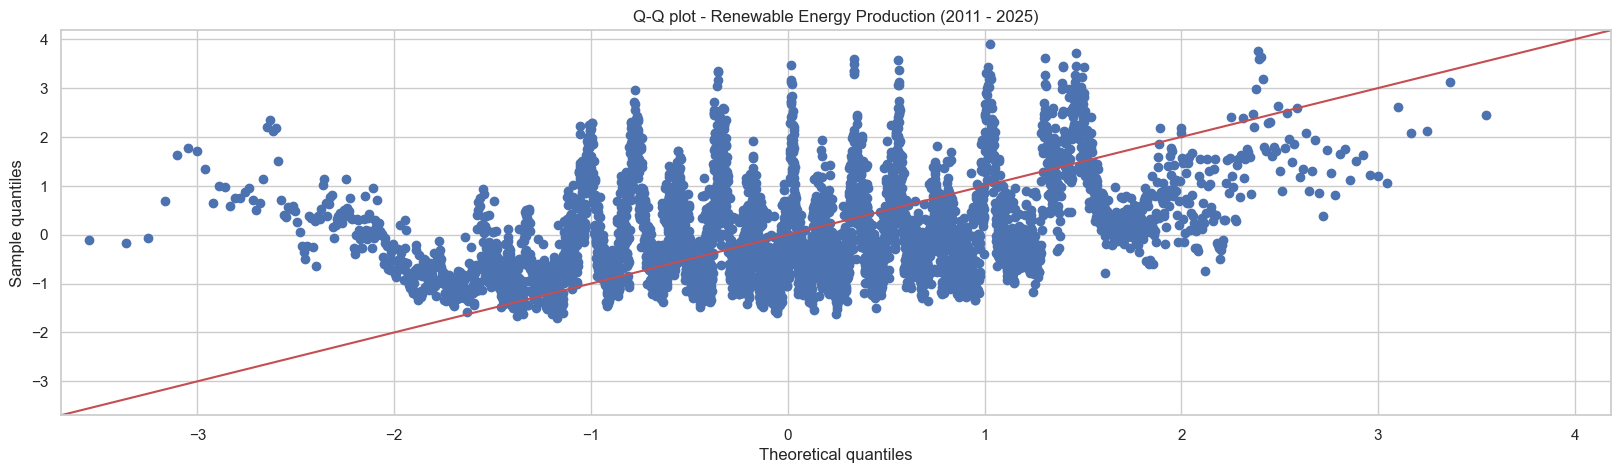

In [150]:
# Q-Q plot
# Compare time series against a standard normal curve
qqplot(df_renewable.values, stats.distributions.norm, fit=True, line='45')
plt.title('Q-Q plot - '+title_renewable);
plt.ylabel('Sample quantiles')
plt.xlabel('Theoretical quantiles')
plt.grid(True)

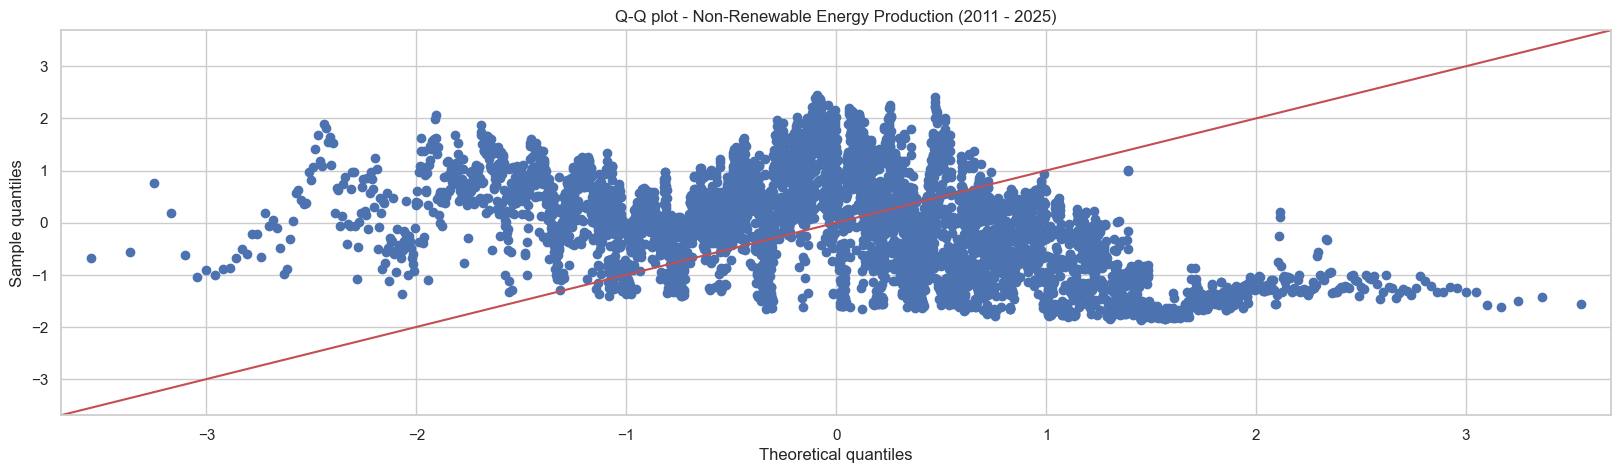

In [152]:
# Q-Q plot
# Compare time series against a standard normal curve
qqplot(df_non_renewable.values, stats.distributions.norm, fit=True, line='45')
plt.title('Q-Q plot - ' +title_non_renewable);
plt.ylabel('Sample quantiles')
plt.xlabel('Theoretical quantiles')
plt.grid(True)

### Quebras de estrutura 

Renewable Energy Production (2011 - 2025) - CUSUM Algorithm


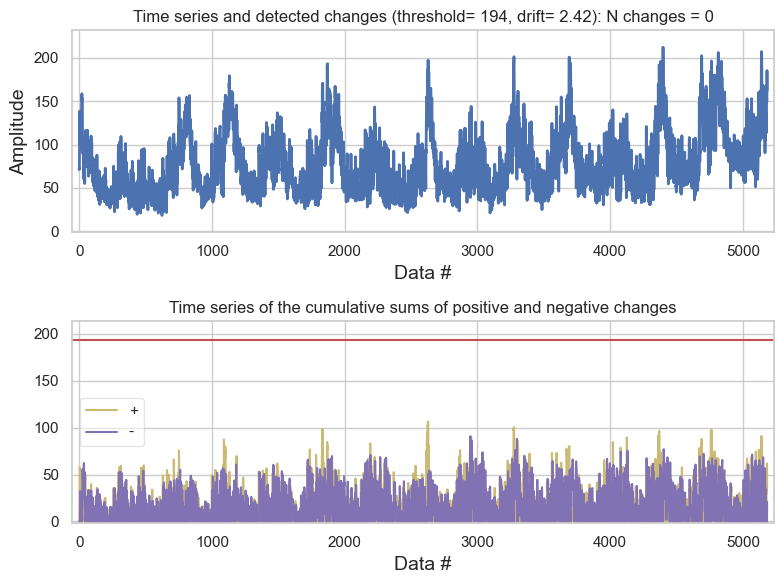

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [175]:
# Suggestions (attention to seasonal series)
threshold = (max(df_renewable.values)-min(df_renewable.values))/1
drift = (max(df_renewable.values)-min(df_renewable.values))/80

#Manual values
#threshold=125 #increases the amplitude, raising the alarm zone barrier
#drift = 1;

print(title_renewable + ' - CUSUM Algorithm')
detect_cusum(df_renewable.values, threshold, drift, True, True)

Non-Renewable Energy Production (2011 - 2025) - CUSUM Algorithm


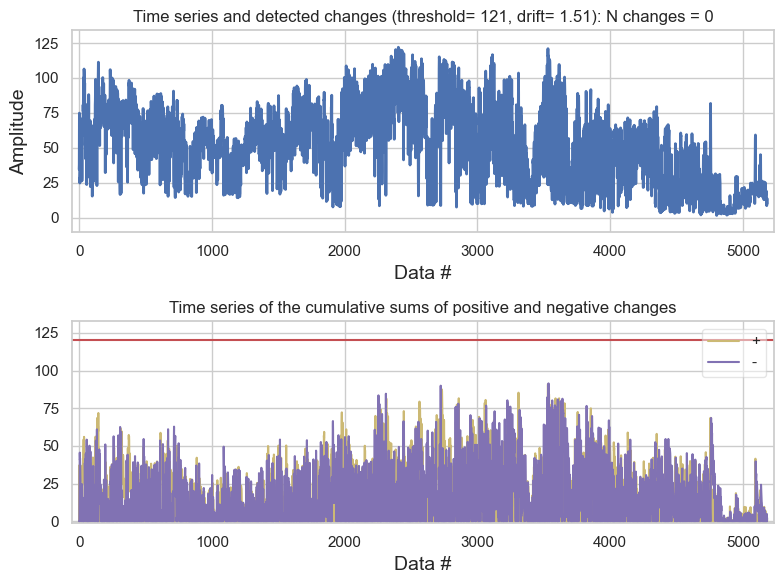

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [176]:
# Suggestions (attention to seasonal series)
threshold = (max(df_non_renewable.values)-min(df_non_renewable.values))/1
drift = (max(df_non_renewable.values)-min(df_non_renewable.values))/80

#Manual values
#threshold=125 #increases the amplitude, raising the alarm zone barrier
#drift = 1;

print(title_non_renewable + ' - CUSUM Algorithm')
detect_cusum(df_non_renewable.values, threshold, drift, True, True)

# Análise inferencial

#### testar se a kurtuse da nossa serie segue uma distribuição normal
    - h0 : A kurtose da série segue uma distribuição normal. 
    - h1 : A kurtose da série não segue uma distribuição normal.

    rejeitamos h0 caso p-value seja inferior a 0.05


In [184]:
# Kurtosis
# Measures height and sharpness of the central peak relative to that of a standard bell curve
k, kpval = kurtosistest(df_renewable)
kurtosis_val = kurtosis(df_renewable, fisher=True)
print("Kurtosis Test for " + serie_renewable)
print("Statistic: %.4f" % k[0])
print("p-value: %.4f" % kpval[0])
print(" ")
print("Kurtosis value: %.4f" % kurtosis_val[0])

Kurtosis Test for Energy Renewable
Statistic: 6.1621
p-value: 0.0000
 
Kurtosis value: 0.5181


In [183]:
k, kpval = kurtosistest(df_non_renewable)
kurtosis_val = kurtosis(df_non_renewable, fisher=True)
print("Kurtosis Test for " + serie_non_renewable)
print("Statistic: %.4f" % k[0])
print("p-value: %.4f" % kpval[0])
print(" ")
print("Kurtosis value: %.4f" % kurtosis_val[0])

Kurtosis Test for Energy Non-Renewable
Statistic: -21.6436
p-value: 0.0000
 
Kurtosis value: -0.8147


#### testar se a swek da nossa serie segue uma distribuição normal
    - h0 : A skew da série segue uma distribuição normal.
    - h1 : A skew da série não segue uma distribuição normal.

    rejeitamos h0 caso p-value seja inferior a 0.05


In [194]:
# Skewness test for renewable energy production
s_renewable, spval_renewable = skewtest(df_renewable)
skew_val_renewable = skew(df_renewable)
print("Skew Test for " + serie_renewable)
print("Statistic: %.4f" % s_renewable[0])
print("p-value: %.4f" % spval_renewable[0])
print(" ")
print("Skewness value: %.4f" % skew_val_renewable[0])
print("\n")
# Skewness test for non-renewable energy production
s_non_renewable, spval_non_renewable = skewtest(df_non_renewable)
skew_val_non_renewable = skew(df_non_renewable)
print("Skew Test for " + serie_non_renewable)
print("Statistic: %.4f" % s_non_renewable[0])
print("p-value: %.4f" % spval_non_renewable[0])
print(" ")
print("Skewness value: %.4f" % skew_val_non_renewable[0])

Skew Test for Energy Renewable
Statistic: 24.0712
p-value: 0.0000
 
Skewness value: 0.9608


Skew Test for Energy Non-Renewable
Statistic: 0.9778
p-value: 0.3282
 
Skewness value: 0.0332


#### testar se a série segue uma distribuição normal com o teste Jarque-Bera
- h0 : A série segue uma distribuição normal.
- h1 : A série não segue uma distribuição normal.


Rejeitamos h0 caso o p-value seja inferior a 0.05

In [ ]:

# Jarque-Bera goodness of fit test on sample data for renewable energy production
jb_renewable, jbpval_renewable = stats.jarque_bera(df_renewable)
print("Jarque-Bera Test for " + serie_renewable)
print("Statistic: %.4f" % jb_renewable)
print("p-value: %.4f" % jbpval_renewable)
print("\n")
# Jarque-Bera goodness of fit test on sample data for non-renewable energy production
jb_non_renewable, jbpval_non_renewable = stats.jarque_bera(df_non_renewable)
print("Jarque-Bera Test for " + serie_non_renewable)
print("Statistic: %.4f" % jb_non_renewable)
print("p-value: %.4f" % jbpval_non_renewable)

Jarque-Bera Test for Energy Renewable
Statistic: 855.5961
p-value: 0.0000
Jarque-Bera Test for Energy Non-Renewable
Statistic: 144.3322
p-value: 0.0000



#### Teste de Hipótese para o Teste de Dickey-Fuller Aumentado (ADF)

- Hipótese Nula (H0): A série temporal possui uma raiz unitária, ou seja, não é estacionária.
- Hipótese Alternativa (H1): A série temporal não possui uma raiz unitária, ou seja, é estacionária.

Rejeitamos H0 caso o valor-p seja inferior a 0.05.


In [193]:
# Augmented Dickey-Fuller Test for Renewable Energy Production
result_renewable = adfuller(df_renewable.values.flatten(), regression='c')
print("Augmented Dickey-Fuller Test for " + serie_renewable)
print("ADF Statistic: %.4f" % result_renewable[0])
print("p-value: %.4f" % result_renewable[1])
print("Used lags: %d" % result_renewable[2])
print("Num obs: %d" % result_renewable[3])
d_renewable = OrderedDict(sorted(result_renewable[4].items(), key=lambda t: t[1]))
for key, value in d_renewable.items():
    print("\t%s: %.3f" % (key, value))
print("\n")
# Augmented Dickey-Fuller Test for Non-Renewable Energy Production
result_non_renewable = adfuller(df_non_renewable.values.flatten(), regression='c')
print("Augmented Dickey-Fuller Test for " + serie_non_renewable)
print("ADF Statistic: %.4f" % result_non_renewable[0])
print("p-value: %.4f" % result_non_renewable[1])
print("Used lags: %d" % result_non_renewable[2])
print("Num obs: %d" % result_non_renewable[3])
d_non_renewable = OrderedDict(sorted(result_non_renewable[4].items(), key=lambda t: t[1]))
for key, value in d_non_renewable.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey-Fuller Test for Energy Renewable
ADF Statistic: -4.8054
p-value: 0.0001
Used lags: 29
Num obs: 5154
	1%: -3.432
	5%: -2.862
	10%: -2.567


Augmented Dickey-Fuller Test for Energy Non-Renewable
ADF Statistic: -3.6574
p-value: 0.0048
Used lags: 33
Num obs: 5150
	1%: -3.432
	5%: -2.862
	10%: -2.567



#### Teste de Hipótese para o Teste KPSS

- Hipótese Nula (H0): A série temporal é estacionária.
- Hipótese Alternativa (H1):  A série temporal não é estacionária.

Rejeitamos H0 caso o valor-p seja inferior a 0.05.
```

In [195]:

# Test for non-renewable energy production
result_non_renewable = kpss(df_non_renewable.values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie_non_renewable)
print("KPSS Statistic: %.4f" % result_non_renewable[0])
print("Critical Values:")
d_non_renewable = OrderedDict(sorted(result_non_renewable[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d_non_renewable.items():
    print("\t%s: %.3f" % (key, value))
    # see: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
result = kpss(df[df.columns.values[0]].values, regression='c')
print("\n")
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("KPSS Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Non-Renewable
KPSS Statistic: 4.1529
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Production
KPSS Statistic: 0.5995
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
